In [1]:
import scipy.io as sio
import scipy
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as op
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import os
import torchvision.transforms as tt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as Fun
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
import random
from model import U2NET

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_input = []
train_answer = []
test_input = []
test_answer = []
for SIR in range(0,11):
    data= sio.loadmat('/home2/LIG/BPSK_LFM_Overlap_data/sir_'+str(SIR)+'_dB.mat')
    overlap = data['overlap_stft']
    radar = data['lfm_stft']
    train_overlap = overlap[0:250]
    test_overlap = overlap[250:300]
    train_radar = radar[0:250]
    test_radar = radar[250:300]
    
    train_input.append(train_overlap)
    train_answer.append(train_radar)
    
    test_input.append(test_overlap)
    test_answer.append(test_radar)


/home/siho0201/anaconda3/envs/dl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cv2
def otsu_thresholding(images):
    # 결과를 저장할 빈 배열을 생성합니다.
    binary_images = np.zeros_like(images)

    for idx, image in enumerate(images):
        image = image.astype(np.uint8)
        _, binary_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # 결과를 binary_images 배열에 저장합니다.
        binary_images[idx] = binary_img

    return binary_images

def normalize(images):
    nor_images = np.zeros_like(images)
    for idx, image in enumerate(images):
        # 이미지의 픽셀 값 범위를 0 ~ 255로 변환합니다.
        min_val = image.min()
        max_val = image.max()
        img = (image - min_val) / (max_val - min_val) * 255
        nor_images[idx] = img

    return nor_images

def iq(input):
    I = np.real(input)
    Q = np.imag(input)

    I_channel = np.expand_dims(I, axis=1)  # 가장 앞쪽 차원에 채널 추가
    Q_channel = np.expand_dims(Q, axis=1)  # 가장 앞쪽 차원에 채널 추가

    output_data = np.concatenate((I_channel, Q_channel), axis=1) 
    return output_data


train_input = np.array(train_input)
train_answer = np.array(train_answer)
test_input = np.array(test_input)
test_answer = np.array(test_answer)


train_input = iq(train_input)
train_answer = iq(train_answer)
test_input = iq(test_input)
test_answer = iq(test_answer)

X_train = train_input.reshape(-1,2,128,256)
y_train = train_answer.reshape(-1,2,128,256)
X_val = test_input.reshape(-1,2,128,256)
y_val = test_answer.reshape(-1,2,128,256)

# X_train = normalize(X_train)
# X_val = normalize(X_val)
# y_train = normalize(y_train)
# y_val = normalize(y_val)



In [ ]:
print(X_train[1][1])
print(X_val[1][1])

[[ 1.56326609e-05 -7.98048154e-05 -1.05585189e-04 ... -3.53757915e-05
  -8.84412932e-05 -2.69336694e-05]
 [ 2.43338320e-04  4.89723992e-04  6.73774479e-04 ...  4.61173510e-04
   2.38079686e-04  5.38663972e-05]
 [-3.97735038e-04 -6.29779073e-04 -6.15307982e-04 ... -6.56909570e-04
  -3.48454869e-04  1.62199780e-04]
 ...
 [ 2.46330110e-04  5.02386205e-04  6.74673656e-04 ...  4.83830862e-04
   2.27199973e-04  4.88438188e-05]
 [ 1.71357395e-05 -7.34728934e-05 -1.05123425e-04 ... -2.40654234e-05
  -9.38719625e-05 -2.94586743e-05]
 [-1.16204518e-04 -1.56522013e-04 -1.55270853e-04 ... -1.03954568e-04
  -1.35338178e-04 -5.92499090e-05]]
[[ 4.27320644e-05  1.05390662e-04  1.26244511e-04 ...  2.10439387e-06
  -1.08273452e-04 -2.07106751e-04]
 [ 9.88284304e-05  1.45224609e-04  9.17793206e-05 ...  1.64295782e-05
   3.17346050e-04  5.36086745e-04]
 [-8.56952110e-05 -2.18060288e-04 -3.43393637e-04 ... -7.29083124e-06
  -5.35742803e-04 -8.76146480e-04]
 ...
 [ 9.26192592e-05  1.34534920e-04  9.6168970

In [3]:
class Train_data(Dataset): 
  def __init__(self):
    self.x_data = X_train
    self.y_data = y_train
   
    # self.y_data = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]

 
  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx].astype(np.float32)
    y = self.y_data[idx].astype(np.float32)
    # x = x/255
    # y = y/255

    x = torch.tensor(x,dtype = torch.float32)
    y = torch.tensor(y,dtype = torch.float32)
    # x = Fun.normalize(x,p=2,dim=1)
    # y = Fun.normalize(y,p=2,dim=1)
    # print(x)
    # print(y)
    # y = Fun.one_hot(y,num_classes =4)
    return x, y

class val_data(Dataset): 
  def __init__(self):
    self.x_data = X_val
    self.y_data = y_val
   
    # self.y_data = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]

 
  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx].astype(np.float32)
    y = self.y_data[idx].astype(np.float32)
    # x = x/255
    # y = y/255


    x = torch.tensor(x,dtype = torch.float32)
    y = torch.tensor(y,dtype = torch.float32)
    # x = Fun.normalize(x,p=2,dim=1)
    # y = Fun.normalize(y,p=2,dim=1)
    # print(y)
    # y = Fun.one_hot(y,num_classes =4)
    return x, y

train_dataset = Train_data()
val_dataset = val_data()
# transform = transforms.Compose([transforms.Normalize(mean=0.5,std=0.5)])
batch_size =64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [4]:
MSE_loss = nn.MSELoss()
net = U2NET(2,2).to(DEVICE)
# if (DEVICE.type == 'cuda') and (torch.cuda.device_count() > 1):
#     print('Multi GPU activate')
#     net = nn.DataParallel(net, device_ids = list(range(NGPU)))
# net.to(DEVICE)
optimizer = op.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

def muti_MSE_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):

	loss0 = MSE_loss(d0,labels_v)
	loss1 = MSE_loss(d1,labels_v)
	loss2 = MSE_loss(d2,labels_v)
	loss3 = MSE_loss(d3,labels_v)
	loss4 = MSE_loss(d4,labels_v)
	loss5 = MSE_loss(d5,labels_v)
	loss6 = MSE_loss(d6,labels_v)

	loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
	print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n"%(loss0.data.item(),loss1.data.item(),loss2.data.item(),loss3.data.item(),loss4.data.item(),loss5.data.item(),loss6.data.item()))

	return loss0, loss

def saveModel():
    path = "./U2net_IQ.pth"
    torch.save(net.state_dict(),path)

epoch_num = 1000
batch_size_train = 16
batch_size_val = 1
train_num = 0
val_num = 0

ite_num = 0
running_loss = 0.0
running_tar_loss = 0.0
ite_num4val = 0
save_frq = 2000 # save the model every 2000 iterations

print("----------------------Train start------------------------")
for epoch in range(0,epoch_num):
	net.train  # Train loop
	for data in trainloader:
		ite_num = ite_num + 1
		ite_num4val = ite_num4val + 1
		train_inputs, train_labels = data
		# print(train_inputs)
		train_inputs = train_inputs.to(DEVICE) 
		train_labels = train_labels.to(DEVICE) 
		optimizer.zero_grad() 
		# print(train_inputs.size())
		# print(train_labels.size())
		d0, d1, d2, d3, d4, d5, d6  = net(train_inputs) 
		# print(outputs.size())
		loss2, loss = muti_MSE_loss_fusion(d0, d1, d2, d3, d4, d5, d6, train_labels)
		loss.backward()
		optimizer.step()
		running_loss += loss.data.item()
		running_tar_loss += loss2.data.item()
		del d0, d1, d2, d3, d4, d5, d6, loss2, loss 

		print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
        epoch + 1, epoch_num, (epoch+ 1) * batch_size, train_num, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))
		if epoch % 5 == 0:
			saveModel()
			print('savemodel')
        	

----------------------Train start------------------------


/home/siho0201/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


l0: 7.754320, l1: 8.266368, l2: 7.881188, l3: 8.200937, l4: 7.928511, l5: 7.801641, l6: 7.715678

[epoch:   1/1000, batch:    64/    0, ite: 1] train loss: 55.548645, tar: 7.754320 
savemodel
l0: 11.856810, l1: 7.783502, l2: 10.005526, l3: 12.887450, l4: 18.395813, l5: 42.346268, l6: 25.102036

[epoch:   1/1000, batch:    64/    0, ite: 2] train loss: 91.963028, tar: 9.805565 
savemodel
l0: 8.116051, l1: 6.350590, l2: 7.936254, l3: 8.262845, l4: 8.986973, l5: 14.845023, l6: 9.116409

[epoch:   1/1000, batch:    64/    0, ite: 3] train loss: 82.513400, tar: 9.242393 
savemodel
l0: 8.150847, l1: 5.552253, l2: 7.862607, l3: 8.111745, l4: 9.529976, l5: 12.924454, l6: 9.639865

[epoch:   1/1000, batch:    64/    0, ite: 4] train loss: 77.327987, tar: 8.969507 
savemodel
l0: 9.027530, l1: 6.288388, l2: 9.745358, l3: 9.840275, l4: 10.563307, l5: 13.130116, l6: 11.493561

[epoch:   1/1000, batch:    64/    0, ite: 5] train loss: 75.880096, tar: 8.981111 
savemodel
l0: 8.732172, l1: 5.470038, l

: 

In [ ]:
torch.cuda.empty_cache()
model = UNet()
model.load_state_dict(torch.load('overlap_u-net_iq.pth'))
model.eval()
model.to(DEVICE)

inputs_arr = []
labels_arr = []
pred_arr = []
with torch.no_grad(): 
    for i, data in enumerate(testloader, 0): 
        test_inputs, test_labels = data 
        test_inputs = test_inputs.to(DEVICE) 
        test_labels = test_labels.to(DEVICE) 
        predicted_outputs = model(test_inputs) 
        inputs_arr.append(test_inputs)
        labels_arr.append(test_labels)
        pred_arr.append(predicted_outputs)



In [ ]:
import scipy.io

pred_arr_cpu = [pred_arr[i].cpu().numpy() for i in range(len(pred_arr))]
pred_arr_np = np.concatenate(pred_arr_cpu, axis=0)
pred_arr_np = np.squeeze(pred_arr_np)
# pred_label = otsu_thresholding(pred_arr_np)
scipy.io.savemat('pred_label_iq.mat', {'pred_label': pred_arr_np})

In [ ]:
print(pred_arr_np.shape)
sample = pred_arr_np[1][1]
sample2 = X_val[1][1]
print(np.max(sample))



(550, 2, 128, 256)
38.42619


(128, 256)


/home/siho0201/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == "__main__":


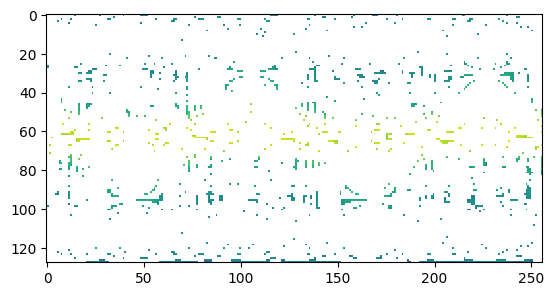

In [ ]:
# 첫 번째 미니 배치에서 이미지를 선택합니다.
sample_idx = 2  # 원하는 이미지 인덱스를 선택하세요.

input_images = [inputs_arr[i][sample_idx].cpu().numpy().squeeze() for i in range(len(inputs_arr))]
label_images = [labels_arr[i][sample_idx].cpu().numpy().squeeze() for i in range(len(labels_arr))]
pred_images = [pred_arr[i][sample_idx].cpu().numpy().squeeze() for i in range(len(pred_arr))]
print(input_images[0][1].shape)
# 각각의 이미지를 플롯합니다.
plt.imshow(np.log(input_images[0][1]))
# plot_images(label_images[0], 'Label Images')
# plot_images(pred_images[0], 'Predicted Images')
plt.show()